<a href="https://colab.research.google.com/github/andreacini/coesi-ml/blob/master/03_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 03: Classification and Deep Neural Networks

In this lab we are going to focus on some practical aspects of building deep neural networks. 

We will focus on three main tasks: 

1. Building a **dense** classifier for images of numerical digits;
2. Building a **convolutional** classifier for images of numerical digits;
3. **Fine-tuning** a deep network to classify images of cats and dogs;

We will use TF/Keras throughout this lab, but the same things can be done with little effort in any deep learning frameworks. As usual, we encourage you to try and implement everything on your own from scratch.

Let's get started...

## MNIST

The **Modified National Institute of Standards and Technology database** is a large collection of handwritten digits that is widely used in machine learning as a benchmark for computer vision algorithms.   
The dataset consists of 70000 images of handwritted digits. All images are 28 pixels by 28 pixels, in 8-bit grayscale (i.e., each pixel is represented by an integer value in the 0-255 range), and are equally divided into 10 classes.

MNIST is usually considered as a multi-class classification problem, where the goal is to map each image to its corresponding class. 

Although nowadays MNIST is regarded as solved, machine learning practitioners like to joke that while it's true that if something works on MNIST, it may not work in the real world, it is also true that if it **doesn't** work on MNIST, it will surely not work in the real world.


Let's look at the data...





In [48]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

np.random.seed(20)

from keras.datasets import mnist

# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

(-0.5, 27.5, 27.5, -0.5)

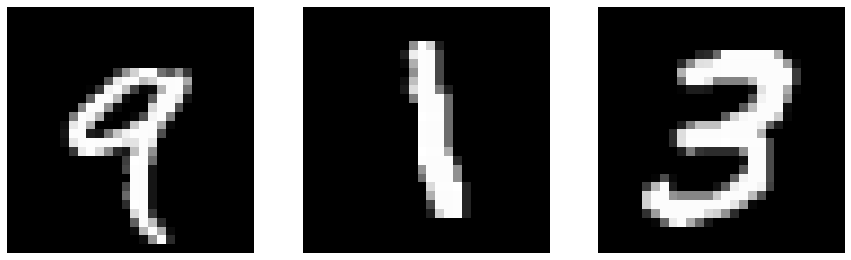

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(x_train[4], cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(x_train[6], cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(x_train[7], cmap='gray');
plt.axis('off')

## Dense classifier
Now let's build a neural network with the tools that we have seen so far, i.e., using only dense layers.

We start by pre-processing the images and reshaping them as vectors.

In [50]:
# Reshape to vectors
x_train = x_train.reshape(-1, 28 * 28)  # shape: (60000, 784)
x_test = x_test.reshape(-1, 28 * 28)    # shape: (10000, 784)

# Normalize to 0-1 range
x_train = x_train / 255.
x_test = x_test / 255.

We also have to pre-process our targets in order to perform multi-class classification. We will use **one-hot encoding** to represent our numerical labels (0-9) as sparse binary vectors. For instance, the one-hot encoding of label 3 will be $[0, 0, 0, 1, 0 ,0 ,0, 0, 0, 0]$.

In [51]:
# Pre-process targets
from keras import utils
n_classes = 10
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

Now we build a neural classifier using the same tools that we saw in the previous lab. Remember that we reshaped our inputs to be vectors, so we are in the same familiar setting as always.

However, this time we will be dealing with multi-class classification, which means that our output layer will have 10 possible outputs instead of a single one.
Moreover, the sigmoid activation function that we used in our previous binary classifiers will be replaced by the normalized **softmax** function, which will give us a **probability distribution** over the possible labels:

$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

where $K$ is the number of classes that we have. 

In [52]:
from keras import Sequential
from keras.layers import Dense
from keras import optimizers

# Build model

model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(28*28, )))
model.add(Dense(n_classes, activation='softmax'))

# Compile model
model.compile(optimizer=optimizers.SGD(lr=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


We can now train and evaluate the model using Keras' `fit` method. 

In [53]:
# Train model
batch_size = 32
epochs = 10
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.1)

# Evaluate model
scores = model.evaluate(x_test, y_test)
print('Test loss: {} - Accuracy: {}'.format(*scores))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 37us/step - loss: 0.6539 - acc: 0.8352 - val_loss: 0.3403 - val_acc: 0.9108
Epoch 2/10
54000/54000 [==============================] - 2s 31us/step - loss: 0.3723 - acc: 0.8968 - val_loss: 0.2817 - val_acc: 0.9245
Epoch 3/10
54000/54000 [==============================] - 2s 31us/step - loss: 0.3268 - acc: 0.9080 - val_loss: 0.2564 - val_acc: 0.9305
Epoch 4/10
54000/54000 [==============================] - 2s 32us/step - loss: 0.3013 - acc: 0.9151 - val_loss: 0.2390 - val_acc: 0.9345
Epoch 5/10
54000/54000 [==============================] - 2s 33us/step - loss: 0.2820 - acc: 0.9203 - val_loss: 0.2255 - val_acc: 0.9375
Epoch 6/10
54000/54000 [==============================] - 2s 32us/step - loss: 0.2665 - acc: 0.9244 - val_loss: 0.2155 - val_acc: 0.9408
Epoch 7/10
54000/54000 [==============================] - 2s 31us/step - loss: 0.2524 - acc: 0.9287 - val_loss: 0.2040 - val_acc:

So far, so good, right? Everything was in our domain of competence and we were able to build a pretty good classifier.

However, we can easily see that our classifier is actually not as good as we think. In particular, we can show that the dense network does not have the property of **translation invariance**, meaning that if we move the content of our images around too much, the classifier quickly fails.

10000/10000 [==============================] - 0s 14us/step
Test loss: 4.996412370300293 - Accuracy: 0.1325


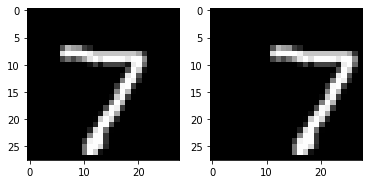

In [59]:
# Take the test data and shift its contents to the right by p pixels
p = 5
x_test_roll = np.roll(x_test.reshape(-1, 28, 28), p, axis=-1)
plt.subplot(121)
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
plt.subplot(122)
plt.imshow(x_test_roll[0], cmap='gray');

# Evaluate the model on the shifted data
x_test_roll = x_test_roll.reshape(-1, 28 * 28)
scores = model.evaluate(x_test_roll, y_test)
print('Test loss: {} - Accuracy: {}'.format(*scores))

## Convolutional neural networks

To solve the issue of translation invariance, one possibility is to adopt **convolutional neural networks** (CNNs) instead of the classical dense ones. 

CNNs were first introduced by Kunihiko Fukushima in 1980, and were later popularized by Y. LeCun, when he successfully applied backpropagation to train CNNs on MNIST. 

![alt text](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

Let's re-build our classifier from scratch, using convolutional layers instead of fully connected ones. 

In [60]:
# Load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We still normalize the data to the 0-1 range, but this time we do not reshape the images into vectors. 
Instead, we add a new dimension which explicitly represents the different channels of our images. In the case of MNIST, we only have one 8-bit channel, so we only need to add a "fake" dimension at the of our data in order to have a 4D tensor of shape `(None, 28, 28, 1)`. 
If we had RGB images, they would be represented as tensors of shape `(None, 28, 28, 3)`.

We also one-hot encode the labels as we did before.


In [61]:
# Normalize to 0-1 range
x_train = x_train / 255.
x_test = x_test / 255.

# Add channels dimension
x_train = x_train[..., None]
x_test = x_test[..., None]

# Pre-process targets
n_classes = 10
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

So far the only difference from the previous model is the way in which we take the input. Let's see how to build a model that knows how to process these images using convolutional layers. 

In [64]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

# Build model
model = Sequential()
model.add(Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               589952    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1290      
Total params: 596,042
Trainable params: 596,042
Non-trainable params: 0
_________________________________________________________________


To train and evaluate the model, we do exactly as we did before.

In [ ]:
# Train model
batch_size = 32
epochs = 10
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs)

# Evaluate model
scores = model.evaluate(x_test, y_test)
print('Test loss: {} - Accuracy: {}'.format(*scores))

Epoch 1/10
 6784/60000 [==>...........................] - ETA: 41s - loss: 0.4403 - acc: 0.8631

Now let's see if the CNN is actually more robust to translations w.r.t. the dense net. We can run the same test as before, by shifting images to the right and evaluating the performance on the shifted test set. 

10000/10000 [==============================] - 1s 61us/step
Test loss: 1.2425784919396043 - Accuracy: 0.8039


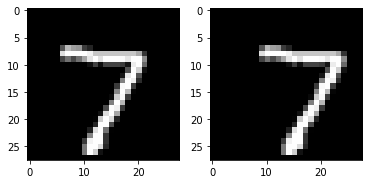

In [42]:
# Take the test data and shift its contents to the right by p pixels
p = 2
x_test_roll = np.roll(x_test, p, axis=2)
plt.subplot(121)
plt.imshow(x_test[0, ..., 0], cmap='gray')
plt.subplot(122)
plt.imshow(x_test_roll[0, ..., 0], cmap='gray');

# Evaluate the model on the shifted data
scores = model.evaluate(x_test_roll, y_test)
print('Test loss: {} - Accuracy: {}'.format(*scores))

Let's check some of the misclassified images.

In [ ]:
fig = plt.figure(figsize=(20, 2))
cols = 4
miss = 0
for i in range(1000):
    x = x_test[i]
    y = np.argmax(y_test[i])
    y_hat = np.argmax(model.predict(x[None]).squeeze())
    if y != y_hat:
        ax = fig.add_subplot(1, 5, miss + 1)
        plt.title('Real class: {} , Predicted class: {}'.format(str(y), str(y_hat)))
        plt.imshow(x.squeeze(), cmap='gray')
        plt.axis('off')
        miss += 1
    if miss >= cols:
        plt.show()
        miss = 0
        fig = plt.figure(figsize=(20, 2))

## Extra : Fine-tuning VGG16

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

VGG16 is a 16-layer version of the network used by the VGG team in the ILSVRC-2014 (ImageNet) competition. 
It was one of the first networks that could be properly defined "deep", and it is still used today as a pre-packaged deep architecture for computer vision problems. 

Due to its large number of layers, VGG16 is extremely expensive to train, and requires several hours of compute time on millions of image samples in order to reach a decent classification performance. 

However, after the 2014 competition, the VGG team publicly released the **trained weights** of the network, so that people could use it for classifiying images without needing to re-train the whole net.   
This also means that, while the whole network can only be used for classifying the original 1000 classes of the ILSVRC competition, the convolutional layers of the network can be used as **general-purpose feature extractors** to represent any natural image as a vector. 

By taking the output of the last pooling layer (or any other intermediate layer), we get an abstract description of the input images, which we then can use as input to a classical dense classifier designed specifically for our task. This process is called **fine-tuning**.

For instance, in the following exercise we will take the convolutional block of VGG16, and we will feed its output to a simple binary classifier. This will allow us to train a model for recognizing cats and dogs, using the pre-trained VGG16 as feature extractor for a simpler network that is significantly less expensive to train than the whole VGG16. 

----

For this exercise, we will see some more sophisticated Keras utils for automating the process of loading images from disk. We will also see how we can **augment** our dataset by transforming our images to obtain more variety in the data (e.g., we can flip all images horizontally).

Let's start, as always, from the data. 
We've uploaded a reduced version of [this dataset](https://www.kaggle.com/c/dogs-vs-cats/data) to a SwitchDrive account, and we can download it directly into Colab by using `wget`.

The data will be divided in folders as follows: 

```
data/
 |__train/
     |__cats/  # 1000 images
     |__dogs/  # 1000 images
 |__val/
     |__cats/  # 500 images
     |__dogs/  # 500 images
 |__test/
     |__cats/  # 500 images
     |__dogs/  # 500 images
```
Note that labels are inherently provided by the folder structure.

In [ ]:
# Download the data
!wget https://drive.switch.ch/index.php/s/1YR2C31sSkac3gk/download -O data.zip
!unzip data.zip

We can use Keras' `ImageDataGenerator` class to create an object that will allow us to do several things:

1. Read the images from the folders in batches, without keeping the whole dataset in memory;
2. Automatically resize, rotate, shift, shear, zoom, and flip the images for us in order to perform data augmentation;
3. Automatically create label vectors from the folder structure.

See [here](https://keras.io/preprocessing/image/#imagedatagenerator-class) for all possible options for image augmentation.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import math

img_h, img_w = 150, 150  # Dimensions to which we want to rescale our images
batch_size = 16          # We specify the batch size here, so that the generator will know how many files to read

# Create the ImageDataGenerator for training and val/test images.
# Note that we only need to augment the training data.
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Create generators for the three data splits
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    'data/val',
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='binary'
)

The VGG16 network architecture and weights [can be easily found online](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3), but because it's so popular, it is also included by default in Keras. 

In [ ]:
from keras import applications

# Build the VGG16 network and download pre-trained weights.
# We remove the last dense layers because we will train our own. The rest of the
# network will be "frozen", i.e., made not trainable.
vgg16 = applications.VGG16(weights='imagenet',  
                           include_top=False, 
                           input_shape=(img_h, img_w, 3))
vgg16.trainable = False

We can now use the convolutional part of VGG16 as if it were any other `keras.Layer` (in fact, `keras.Model` inherits from `keras.Layer`). Note that in the last line of code of the previous block, we set the loaded VGG16 model as not trainable. This means that the weights of VGG16 will not be updated during backpropagation (the network is still differentiable, but we do not take the gradient w.r.t. those weights).

Let's build a classifier based on the pre-trained VGG16: 

In [ ]:
# Build a classifier model to put on top of VGG16 convolutional layers
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
              metrics=['accuracy'])

And now we train it as usual, except that this time we use the `fit_generator` method of `Model`, and the `generator` object created by `ImageDataGenerator`.

In [ ]:
# Train the model
n_train_samples = 2000
n_val_samples = 1000
n_test_samples = 1000
epochs = 10
model.fit_generator(train_generator,
                    steps_per_epoch=math.ceil(n_train_samples / batch_size),
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=math.ceil(n_val_samples / batch_size))

# Evaluate model
scores = model.evaluate_generator(test_generator, steps=math.ceil(n_test_samples / batch_size))
print('Test loss: {} - Accuracy: {}'.format(*scores))

**Fun fact**: when the "Cats vs. Dogs" challenge was first released on Kaggle in 2014, computer vision experts posited that a classifier with better than 80% accuracy would be difficult to achieve without a major advance in the state of the art [[source]](https://www.kaggle.com/c/dogs-vs-cats/overview).

As a final step, we can also use the model to classify a single test image as follows:

In [ ]:
# Load a cat image
from skimage import io, transform
img = io.imread('data/test/cats/cat.1999.jpg')
img = transform.resize(img, (img_h, img_w))
plt.imshow(img);
img = img[None, ...]

pred = model.predict(img)[0, 0]
pred_class = int(np.round(pred))
pred_proba = (1 - pred_class) * (1 - pred) + pred_class * pred
print('Image was predicted as being of class {} with probability {:2.2f}%.'.format(pred_class, pred_proba * 100))